In [0]:
import pandas as pd
from google.colab import files
import io

import math
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.python.framework import ops
#from tf_utils import load_dataset, random_mini_batches, convert_to_one_hot, predict

%matplotlib inline

In [0]:
uploaded = files.upload()

Saving color-dev-data.csv to color-dev-data (1).csv


In [0]:
#color_data_df = pd.read_csv(io.StringIO(uploaded["color-data-train.csv"].decode("utf-8")))
#color_test_df = pd.read_csv(io.StringIO(uploaded["color-test-data.csv"].decode("utf-8")))
color_dev_df = pd.read_csv(io.StringIO(uploaded["color-dev-data.csv"].decode("utf-8")))

In [0]:
#Loading dataset from color-data-train.csv. X_train has 4 features red,green,blue,text-color(0 for black,1 for white). Y_train has labels 0("Can't See) or 1("Can See")."
Y_train = np.array(color_data_df["0.4"])
Y_train = np.float32(Y_train.T)
Y_train = Y_train.reshape(1,Y_train.shape[0])             #shape of Y_train = (1,37587)
X_train = np.array(color_data_df.iloc[:,:4])
X_train = np.float32(X_train.T)                           #shape of X_train = (4,37587)

#Normalizing features. Max value for red, green, blue features is 256, so divide each feature value by 256. For "text-color" feature only possible values are 0 or 1. So don't normalize this feature.
X_train[:3,:] = X_train[:3,:]/256

#Same for test set
Y_test = np.array(color_test_df["0.4"])
Y_test = np.float32(Y_test.T)
Y_test = Y_test.reshape(1,Y_test.shape[0])
X_test = np.array(color_test_df.iloc[:,:4])
X_test = np.float32(X_test.T)
#Normalize test features
X_test[:3,:] = X_test[:3,:]/256

#Same for dev set
Y_dev = np.array(color_dev_df["0.4"])
Y_dev = np.float32(Y_dev.T)
Y_dev = Y_dev.reshape(1,Y_dev.shape[0])
X_dev = np.array(color_dev_df.iloc[:,:4])
X_dev = np.float32(X_dev.T)
#Normalize dev features
X_dev[:3,:] = X_dev[:3,:]/256

In [0]:
def create_placeholders(n_x, n_y):
    """
    Creates the placeholders for the tensorflow session.
    
    Arguments:
    n_x -- scalar, size of an image vector (num_px * num_px = 64 * 64 * 3 = 12288)
    n_y -- scalar, number of classes (from 0 to 5, so -> 6)
    
    Returns:
    X -- placeholder for the data input, of shape [n_x, None] and dtype "float"
    Y -- placeholder for the input labels, of shape [n_y, None] and dtype "float"
    """

    X = tf.placeholder("float32", [n_x, None])
    Y = tf.placeholder("float32", [n_y, None])
    
    return X, Y

In [0]:
def initialize_parameters():
    """
    Initializes parameters to build a neural network with tensorflow. The shapes are:
                        W1 : [3, 4]  3 neurons in the first layer, 4 input features
                        b1 : [3, 1]
                        W2 : [1, 3]
                        b2 : [1, 1]
    
    Returns:
    parameters -- a dictionary of tensors containing W1, b1, W2, b2
    """
        
    W1 = tf.get_variable("W1", [3,4], initializer = tf.contrib.layers.xavier_initializer(), dtype="float32")
    b1 = tf.get_variable("b1", [3,1], initializer = tf.zeros_initializer(), dtype="float32")
    W2 = tf.get_variable("W2", [1,3], initializer = tf.contrib.layers.xavier_initializer(), dtype="float32")
    b2 = tf.get_variable("b2", [1,1], initializer = tf.zeros_initializer(), dtype="float32")
    
  
    parameters = {"W1": W1,
                  "b1": b1,
                  "W2": W2,
                  "b2": b2}
    '''
    
    parameters = {'W1': tf.get_variable("W1", initializer = tf.convert_to_tensor(np.array([[ 0.31035033, -0.7829059 , -0.41219217, -0.16607714],
                [-1.3012043 , -3.715908  , -0.24158937,  5.1152887 ],
                [  0.42639863,  4.409025  ,  0.26884907,  0.55255806  ]],
                dtype="float32"))),
                'W2': tf.get_variable("W2", initializer = tf.convert_to_tensor(np.array([[ -0.7082019, 110.77128  , -27.845854 ]], dtype="float32"))),
                'b1': tf.get_variable("b1", initializer = tf.convert_to_tensor(np.array([[-2.8216890e-01],
                [-4.620715e-03],
                [-5.049001e+00]], dtype="float32"))),
                'b2': tf.get_variable("b2", initializer = tf.convert_to_tensor(np.array([[0.98699754]], dtype="float32")))}
    '''
    return parameters

In [0]:
def forward_propagation(X, parameters):
    """
    Implements the forward propagation for the model: LINEAR -> RELU -> LINEAR -> RELU -> LINEAR -> SOFTMAX
    
    Arguments:
    X -- input dataset placeholder, of shape (input size, number of examples)
    parameters -- python dictionary containing your parameters "W1", "b1", "W2", "b2", "W3", "b3"
                  the shapes are given in initialize_parameters

    Returns:
    Z3 -- the output of the last LINEAR unit
    """
    
    # Retrieve the parameters from the dictionary "parameters" 
    W1 = parameters['W1']
    b1 = parameters['b1']
    W2 = parameters['W2']
    b2 = parameters['b2']
   
    Z1 = tf.add(tf.matmul(W1,X), b1)                                              # Z1 = np.dot(W1, X) + b1
    A1 = tf.nn.relu(Z1)                                              # A1 = relu(Z1)
    Z2 = tf.add(tf.matmul(W2,A1), b2)                                              # Z2 = np.dot(W2, a1) + b2
    #A2 = tf.nn.sigmoid(Z2)                                           #final layer use sigmoid as only 2 classes "Can't See" or "Can See"
    
    return Z2

In [0]:
def compute_cost(AL, Y, params):
    """
    Implement the cost function defined by equation (7).

    Arguments:
    AL -- probability vector corresponding to your label predictions, shape (1, number of examples)
    Y -- true "label" vector (for example: containing 0 if non-cat, 1 if cat), shape (1, number of examples)

    Returns:
    cost -- cross-entropy cost
    """
    labels = tf.transpose(Y)
    logits = tf.transpose(AL)
    beta = 0
    #m = Y.shape[1]
    # Compute loss from aL and y.
    cost = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits = logits, labels = labels))
    #cost = tf.divide(tf.reduce_sum(tf.add(tf.matmul(Y,tf.log(tf.transpose(AL))), tf.matmul(tf.subtract(1.0,Y),tf.log(tf.subtract(1.0,tf.transpose(AL))))), tf.multiply(-1.0, m)))
   
    cost = tf.squeeze(cost)      # To make sure your cost's shape is what we expect (e.g. this turns [[17]] into 17).
    
    regularizers = tf.squeeze(tf.nn.l2_loss(tf.squeeze(params["W1"])) + tf.nn.l2_loss(tf.squeeze(params["W2"])))
    cost = tf.squeeze(tf.reduce_mean(cost + beta * regularizers))
    return cost

In [0]:
def random_mini_batches(X, Y, mini_batch_size = 64):
    """
    Creates a list of random minibatches from (X, Y)
    
    Arguments:
    X -- input data, of shape (input size, number of examples)
    Y -- true "label" vector (1 for blue dot / 0 for red dot), of shape (1, number of examples)
    mini_batch_size -- size of the mini-batches, integer
    
    Returns:
    mini_batches -- list of synchronous (mini_batch_X, mini_batch_Y)
    """
    
    m = X.shape[1]                  # number of training examples
    mini_batches = []
        
    # Step 1: Shuffle (X, Y)
    permutation = list(np.random.permutation(m))
    shuffled_X = X[:, permutation]
    shuffled_Y = Y[:, permutation].reshape((1,m))

    # Step 2: Partition (shuffled_X, shuffled_Y). Minus the end case.
    num_complete_minibatches = math.floor(m/mini_batch_size) # number of mini batches of size mini_batch_size in your partitionning
    for k in range(0, num_complete_minibatches):
        mini_batch_X = shuffled_X[:, k*mini_batch_size : (k*mini_batch_size) + mini_batch_size]
        mini_batch_Y = shuffled_Y[:, k*mini_batch_size : (k*mini_batch_size) + mini_batch_size]

        mini_batch = (mini_batch_X, mini_batch_Y)
        mini_batches.append(mini_batch)
    
    # Handling the end case (last mini-batch < mini_batch_size)
    if m % mini_batch_size != 0:
        filled_egs = num_complete_minibatches * mini_batch_size
        mini_batch_X = shuffled_X[:, filled_egs :]
        mini_batch_Y = shuffled_Y[:, filled_egs :]
      
        mini_batch = (mini_batch_X, mini_batch_Y)
        mini_batches.append(mini_batch)
    
    return mini_batches

In [0]:
def model(X_train, Y_train, X_test, Y_test, learning_rate = 0.0001, num_epochs = 1000, minibatch_size = 20, print_cost = True): 
    """
    starting LR = 0.0001
    lambda values 0.01, 0.02, ....
    Implements a three-layer tensorflow neural network: LINEAR->RELU->LINEAR->RELU->LINEAR->SOFTMAX.
    
    Arguments:
    X_train -- training set, of shape (input size = 4, number of training examples = 37587)
    Y_train -- test set, of shape (output size = 6, number of training examples = 1080)
    learning_rate -- learning rate of the optimization
    num_epochs -- number of epochs of the optimization loop
    minibatch_size -- size of a minibatch
    print_cost -- True to print the cost every 100 epochs
    
    Returns:
    parameters -- parameters learnt by the model. They can then be used to predict.
    """
    
    tf.reset_default_graph()                         # to be able to rerun the model without overwriting tf variables
    (n_x, m) = X_train.shape                          # (n_x: input size, m : number of examples in the train set)
    n_y = Y_train.shape[0]                            # n_y : output size
    costs = []                                        # To keep track of the cost
    
  
    # Create Placeholders of shape (n_x, n_y)
    X, Y = create_placeholders(n_x, n_y)

    # Initialize parameters
    parameters = initialize_parameters()
    
    # Forward propagation: Build the forward propagation in the tensorflow graph
    Z3 = forward_propagation(X, parameters)
    
    # Cost function: Add cost function to tensorflow graph
    cost = compute_cost(Z3, Y, parameters)
    
    # Backpropagation: Define the tensorflow optimizer. Use an AdamOptimizer.
    optimizer = tf.train.AdamOptimizer(learning_rate = learning_rate).minimize(cost)
    
    # Initialize all the variables
    init = tf.global_variables_initializer()

    # Start the session to compute the tensorflow graph
    with tf.Session() as sess:
        
        # Run the initialization
        sess.run(init)
        
        # Do the training loop
        for epoch in range(num_epochs):

            epoch_cost = 0.                       # Defines a cost related to an epoch
            num_minibatches = int(m / minibatch_size) # number of minibatches of size minibatch_size in the train set
            minibatches = random_mini_batches(X_train, Y_train, minibatch_size)

            for minibatch in minibatches:

                # Select a minibatch
                (minibatch_X, minibatch_Y) = minibatch
                
                # IMPORTANT: The line that runs the graph on a minibatch.
                # Run the session to execute the "optimizer" and the "cost", the feedict should contain a minibatch for (X,Y).
                _ , minibatch_cost = sess.run([optimizer, cost], feed_dict={X: minibatch_X, Y: minibatch_Y})
               
                
                epoch_cost += minibatch_cost / num_minibatches
             
           
            # Print the cost every epoch
            if print_cost == True and epoch % 100 == 0:
                print ("Cost after epoch %i: %f" % (epoch, epoch_cost))
                #parameters = sess.run(parameters)
                Z3_sigmoid = tf.nn.sigmoid(Z3)
                prediction = np.where(np.array(Z3_sigmoid.eval({X:X_train})) <= 0.5, 0.0, 1.0)
                correct_prediction = tf.equal(np.float32(prediction), Y)
                accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))
                print ("Train Accuracy:", accuracy.eval({X:X_train, Y:Y_train}))
                
                
                prediction = np.where(np.array(Z3_sigmoid.eval({X:X_test})) <= 0.5, 0.0, 1.0)
                correct_prediction = tf.equal(np.float32(prediction), Y)
                accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))
                print("Test Accuray:", accuracy.eval({X:X_test, Y:Y_test}))
            if print_cost == True and epoch % 5 == 0:
                costs.append(epoch_cost)
            

                
        # plot the cost
        plt.plot(np.squeeze(costs))
        plt.ylabel('cost')
        plt.xlabel('iterations (per tens)')
        plt.title("Learning rate =" + str(learning_rate))
        plt.show()
        parameters = sess.run(parameters)
        '''
        # lets save the parameters in a variable
        parameters = sess.run(parameters)
        print ("Parameters have been trained!")

        # Calculate the correct predictions
        correct_prediction = tf.equal(tf.argmax(Z3), tf.argmax(Y))

        # Calculate accuracy on the test set
        accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))

        print ("Train Accuracy:", accuracy.eval({X: X_train, Y: Y_train}))
        '''
        return parameters

Cost after epoch 0: 0.654548
Train Accuracy: 0.6550935
Test Accuray: 0.6570889
Cost after epoch 100: 0.027087
Train Accuracy: 0.9934552
Test Accuray: 0.9933488
Cost after epoch 200: 0.015778
Train Accuracy: 0.9958496
Test Accuray: 0.9953175
Cost after epoch 300: 0.011894
Train Accuracy: 0.996701
Test Accuray: 0.9961955
Cost after epoch 400: 0.009839
Train Accuracy: 0.99717987
Test Accuray: 0.9967276
Cost after epoch 500: 0.008726
Train Accuracy: 0.99779177
Test Accuray: 0.9972863
Cost after epoch 600: 0.007594
Train Accuracy: 0.99805784
Test Accuray: 0.99755234
Cost after epoch 700: 0.006898
Train Accuracy: 0.99824405
Test Accuray: 0.99771196
Cost after epoch 800: 0.006332
Train Accuracy: 0.9985367
Test Accuray: 0.99795145
Cost after epoch 900: 0.005908
Train Accuracy: 0.9986165
Test Accuray: 0.9980046


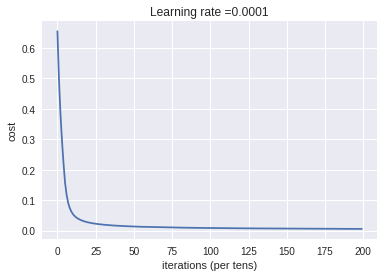

In [0]:
params = model(X_train, Y_train, X_test, Y_test)


In [0]:
print(params)


{'W1': array([[  3.9428747 ,  11.59308   ,   1.8363051 , -16.980663  ],
       [  2.668514  ,   3.8103638 ,   0.84936374,  -1.9624231 ],
       [  0.22013244,  -1.5614797 ,   1.0716099 ,   4.961385  ]],
      dtype=float32), 'b1': array([[-0.38128474],
       [-3.9973104 ],
       [-0.08543456]], dtype=float32), 'W2': array([[ 23.99707  , -17.736904 ,   4.3511972]], dtype=float32), 'b2': array([[-6.6498837]], dtype=float32)}


In [0]:
'''rams = {'W1': np.array([[ 1, 2 ,  3, 4 ],
       [ 5,  6,  7, 8],
       [ 9,  10 ,  11, 12]], dtype="float32"), 'b1': np.array([[1],
       [1 ],
       [1 ]], dtype="float32"), 'W2': np.array([[ 1,  2, 3]], dtype="float32"), 'b2': np.array([[1]], dtype="float32")} '''
params = {'W1': np.array([[  3.9428747 ,  11.59308   ,   1.8363051 , -16.980663  ],
       [  2.668514  ,   3.8103638 ,   0.84936374,  -1.9624231 ],
       [  0.22013244,  -1.5614797 ,   1.0716099 ,   4.961385  ]],
      dtype="float32"), 'b1': np.array([[-0.38128474],
       [-3.9973104 ],
       [-0.08543456]], dtype="float32"), 'W2': np.array([[ 23.99707  , -17.736904 ,   4.3511972]], dtype="float32"), 'b2': np.array([[-6.6498837]], dtype="float32")}

In [0]:
a = np.array([[252,255,94,1]], dtype="float32")

a[:,0:3] = a[:,0:3] / 256

Z3 = forward_propagation(a.T,params)

Z3_sigmoid = tf.nn.sigmoid(Z3)

with tf.Session() as sess:
  #prediction = np.where(np.array(sess.run(Z3_sigmoid)) <= 0.5, 0, 1)
  print(sess.run(Z3_sigmoid))
  print(sess.run(Z3))
  #correct_prediction = tf.equal(prediction, Y_dev)
  #accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))
  #print ("Dev Accuracy:", accuracy.eval())
  

[[0.03617267]]
[[-3.2826083]]
